In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14),(44, 160, 44), (152, 223, 138), (214, 39, 40)]
for i in range(len(colors)):    
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.)  

In [4]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,MaxNLocator

plt.rcParams['xtick.major.pad'] = 12
plt.rcParams['ytick.major.pad'] = 12
plt.rcParams.update({'font.size': 10})

def setPlotProperties(fig,ax):
    majorLocator = MultipleLocator(5)
    majorFormatter = FormatStrFormatter('%d %%')
    ax.xaxis.set_major_locator(majorLocator)
    xlabels = ax.get_xticklabels()
    plt.setp(xlabels[1:], fontsize=11)
    ax.yaxis.set_major_formatter(majorFormatter)
    ylabels = ax.get_yticklabels()
    plt.setp(ylabels, fontsize=11)
    ax.yaxis.grid(b=True, which='major', color='gray', linestyle=':',linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xlabel('Year', fontsize=12,labelpad=12)

In [5]:
def sliding_window(data_array, window=2):  
    length = len(data_array)
    new_list = []  
    for i in range(length):  
        indices = range(max(i - window, 0), min(i + window + 1, length))  
        avg = 0
        for j in indices:  
            avg += data_array[j]  
        avg /= float(len(indices))  
        new_list.append(avg)            
    return np.array(new_list)

In [6]:
def replaceSpecialCharacter(s):
    s=s.strip().replace(' ','_').replace('/','_').replace('+','').replace('(','').replace(')','').replace('-','')
    return s 

In [7]:
infile=file('USPatent_ProductMolecules_And_Properties.csv','r')
lines=infile.readlines()
infile.close()

In [8]:
from collections import namedtuple

In [9]:
propnames=[i.strip() for i in lines[0].strip().split(',')]

In [10]:
propnames2=[replaceSpecialCharacter(i) for i in propnames]

In [11]:
ProductAndProps = namedtuple("ProductAndProps", propnames2)

In [12]:
products=[]
for l in lines[1:]:
    products.append(ProductAndProps._make(l.strip().split(',')))
del lines[:]

In [13]:
differentProducts_g=defaultdict(int)
differentProducts_a=defaultdict(int)

for p in products:
    granted=False
    year=p.Publication_year__Patent_IDs.split()[0].split('_')[0]
    # prefer grants over applications
    for pat in p.Publication_year__Patent_IDs.split():
        if pat.split('_')[-1]=='Grant':
            granted=True
            year=pat.split('_')[0]
            break
    if granted:
        differentProducts_g[int(year)]+=1
    else:
        differentProducts_a[int(year)]+=1

In [14]:
len(products)

628200

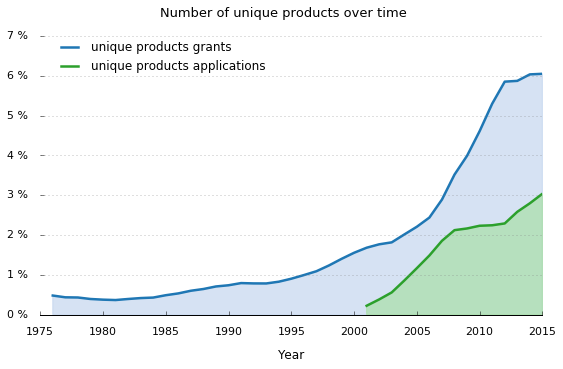

In [15]:
differentProducts_g = sorted(differentProducts_g.items())
years=[x[0] for x in differentProducts_g]
occ=[int(x[1]) for x in differentProducts_g]

differentProducts_a = sorted(differentProducts_a.items())
years2=[x[0] for x in differentProducts_a]
occ2=[int(x[1]) for x in differentProducts_a]

numProds=np.array(occ).sum()+np.array(occ2).sum()
norm_occ=(np.array(occ).astype(float)/numProds)*100
norm_occ2=(np.array(occ2).astype(float)/numProds)*100

fig, ax = plt.subplots(figsize=(9,5),dpi=300)
plt.plot(years,sliding_window(norm_occ), color=colors[0],label="unique products grants",linewidth=2.5)
plt.plot(years2,sliding_window(norm_occ2), color=colors[3],label="unique products applications",linewidth=2.5)
plt.fill_between(years,0,sliding_window(norm_occ),color=colors[1],alpha=0.5)
plt.fill_between(years2,0,sliding_window(norm_occ2),color=colors[4],alpha=0.5)
setPlotProperties(fig,ax)  
lgd=plt.legend(bbox_to_anchor=(0.47, 1.02), frameon=False)
plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)
ttl=fig.suptitle('Number of unique products over time', fontsize=13)

In [16]:
propertyDict=defaultdict(list)
for p in products:
    year=p.Publication_year__Patent_IDs.split()[0].split('_')[0]
    for name in p._fields:
        v = getattr(p, name)
        if name in ['SMILES','Publication_year__Patent_IDs','Num_Lipinski_HBA','Num_Lipinski_HBD']:
            continue
        propertyDict[(int(year),name)].append(float(v))

In [17]:
from scipy import stats

meanPropertyDict=defaultdict()
significantChangePropertyDict=defaultdict()
for k,v in sorted(propertyDict.items()):
    if k[0] > 1976:
        p,pv = stats.ttest_ind(propertyDict[(k[0]-1,k[1])],np.array(v), equal_var = False)
        if pv < 0.05:
            significantChangePropertyDict[k]=True
        else:
            significantChangePropertyDict[k]=False
    else:
        significantChangePropertyDict[k]=False
    meanPropertyDict[k]=np.mean(np.array(v))

In [18]:
props=['Num_rings', 'Aromatic_rings', 'Aromatic_carbocycles', 'Aromatic_heterocycles', 'Aliphatic_rings', \
       'Aliphatic_carbocycles', 'Aliphatic_heterocycles', 'Saturated_rings', 'Saturated_carbocycles', \
       'Saturated_heterocycles', 'Contains_solubilizing_group', 'Num_heavy_atoms', 'Molecular_weight', \
       'Calculated_LogP', 'TPSA', 'Fraction_of_rotatable_bonds', 'Ratio_O_NO_Atoms', 'Fraction_of_heteroatoms', \
       'Fraction_of_SP3_carbons', 'Fraction_of_HBond_acceptors', 'Fraction_of_HBond_donors']

proplabel=['Num rings', 'Aromatic rings', 'Aromatic carbocycles', 'Aromatic heterocycles', 'Aliphatic rings', \
           'Aliphatic carbocycles', 'Aliphatic heterocycles', 'Saturated rings', 'Saturated carbocycles', \
           'Saturated heterocycles', 'Contains solubilizing group', 'Num heavy atoms', 'Molecular weight', \
           'Calculated LogP', 'TPSA', 'Fraction of rotatable bonds', 'Ratio O/(N+O) Atoms', 'Fraction of heteroatoms', \
           'Fraction of SP3 carbons', 'Fraction of H-Bond acceptors', 'Fraction of H-Bond donors']

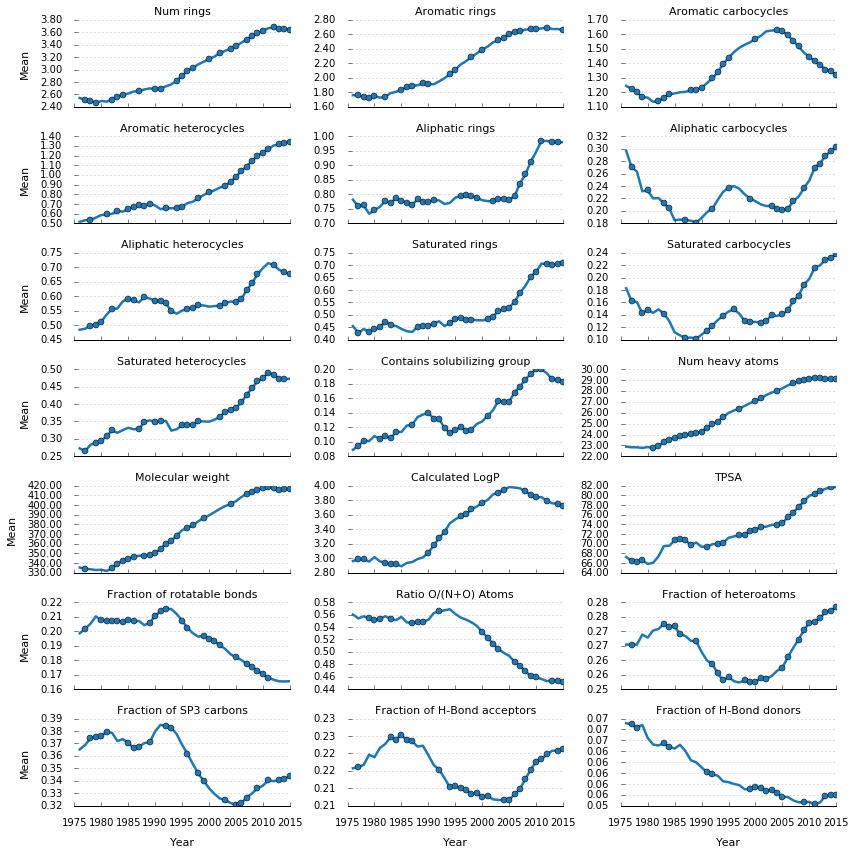

In [19]:
years=set()
propDict=defaultdict(list)
sigDict=defaultdict(list)
for k,v in sorted(meanPropertyDict.items()):
    years.add(k[0])
    propDict[k[1]].append(v)
    sigDict[k[1]].append(significantChangePropertyDict[k])
    
years = sorted(years)
fig,axes = plt.subplots(nrows=7, ncols=3,figsize=(12,12),dpi=300)
count=0
j=0

for l,k in enumerate(props):
    v = propDict[k]
    if j>1:
        ax = axes[count][j]
        count+=1
        j=0
    else:
        ax = axes[count][j]
        j+=1
    smooth_mean = sliding_window(np.array(v), window=2)
    markers=[]
    for n,i in enumerate(sigDict[k]):
        if i:
            markers.append(n)
    
    ax.plot(years,smooth_mean,linewidth=2.5,color=colors[0],marker='o',markevery=markers)
    majorLocator = MultipleLocator(5)
    majorFormatter = FormatStrFormatter('%.2f')
    ax.xaxis.set_major_locator(majorLocator)
    if l < len(props)-3:
        plt.setp( ax.get_xticklabels(), visible=False)
    else:
        ax.set_xlabel('Year', fontsize=11,labelpad=10)
    if j == 1:
        ax.set_ylabel('Mean', fontsize=11,labelpad=10)
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.yaxis.grid(b=True, which='major', color='gray', linestyle=':',linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    ax.set_title(proplabel[l],fontsize=11)
fig.tight_layout()

##### Look at the rule of five violations

In [20]:
outlierLipinski=defaultdict(list)
allProducts=defaultdict(int)
numRulesViolated=defaultdict(int)
moreThan2RulesViolated=defaultdict(int)

for p in products:
    year=p.Publication_year__Patent_IDs.split()[0].split('_')[0]
    allProducts[year]+=1
    rulv=0
    for name in ['Molecular_weight','Calculated_LogP','Num_Lipinski_HBA','Num_Lipinski_HBD']:
        v = getattr(p, name)
    MW=float(p.Molecular_weight)
    logP=float(p.Calculated_LogP)
    HBA=int(p.Num_Lipinski_HBA)
    HBD=int(p.Num_Lipinski_HBD)
    if MW > 500.0:
        outlierLipinski[('MolWt',year)].append(MW)
        rulv+=1
    if logP > 5.0:
        outlierLipinski[('MolLogP',year)].append(logP)
        rulv+=1
    if HBA > 10:
        outlierLipinski[('NumLipinskiHBA',year)].append(HBA)
        rulv+=1
    if HBD > 5:
        outlierLipinski[('NumLipinskiHBD',year)].append(HBD)
        rulv+=1
    numRulesViolated[rulv]+=1
    if rulv>1:
        moreThan2RulesViolated[year]+=1

In [21]:
numRulesViolated

defaultdict(int, {0: 420258, 1: 119852, 2: 77455, 3: 10197, 4: 438})

In [22]:
allprods=float(np.sum(np.array(allProducts.values())))
print numRulesViolated[0]/allprods,numRulesViolated[1]/allprods,numRulesViolated[2]/allprods,numRulesViolated[3]/allprods,numRulesViolated[4]/allprods

0.668987583572 0.190786373766 0.12329672079 0.0162320916905 0.000697230181471


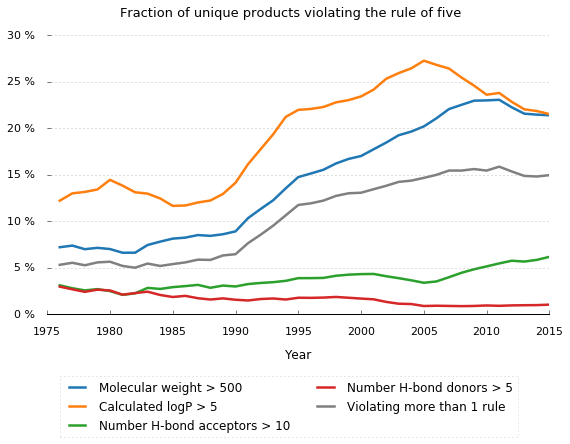

In [23]:
years,years1,years2,years3 = [],[],[],[]
occ,occ1,occ2,occ3 = [],[],[],[]
labels=[]
for k,v in sorted(outlierLipinski.items()):
    if k[0] == 'MolWt':
        years.append(k[1])
        occ.append(100.0*float(len(v))/allProducts[k[1]])
    if k[0] == 'MolLogP':
        years1.append(k[1])
        occ1.append(100.0*float(len(v))/allProducts[k[1]])
    if k[0] == 'NumLipinskiHBA':
        years2.append(k[1])
        occ2.append(100.0*float(len(v))/allProducts[k[1]])
    if k[0] == 'NumLipinskiHBD':
        years3.append(k[1])
        occ3.append(100.0*float(len(v))/allProducts[k[1]])
years4 = np.array(sorted(moreThan2RulesViolated.items()))[:,0]
occ4 = 100*(np.array(sorted(moreThan2RulesViolated.items())).astype(float)[:,1]/\
            np.array(sorted(allProducts.items())).astype(float)[:,1])

fig, ax = plt.subplots(figsize=(9,5),dpi=300)

plt.plot(years,sliding_window(occ),color=colors[0],label="Molecular weight > 500",linewidth=2.5)
plt.plot(years1,sliding_window(occ1),color=colors[2],label="Calculated logP > 5",linewidth=2.5)
plt.plot(years2,sliding_window(occ2),color=colors[3],label="Number H-bond acceptors > 10",linewidth=2.5)
plt.plot(years3,sliding_window(occ3),color=colors[5],label="Number H-bond donors > 5",linewidth=2.5)
plt.plot(years4,sliding_window(occ4),color='gray',label="Violating more than 1 rule",linewidth=2.5)

setPlotProperties(fig,ax)  
lgd=plt.legend(bbox_to_anchor=(0.95, -0.2), frameon=True,ncol=2)
lgd.get_frame().set_facecolor('white')
lgd.get_frame().set_edgecolor('lightgray')
lgd.get_frame().set_linestyle(':')
plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)
ttl=fig.suptitle('Fraction of unique products violating the rule of five', fontsize=13)

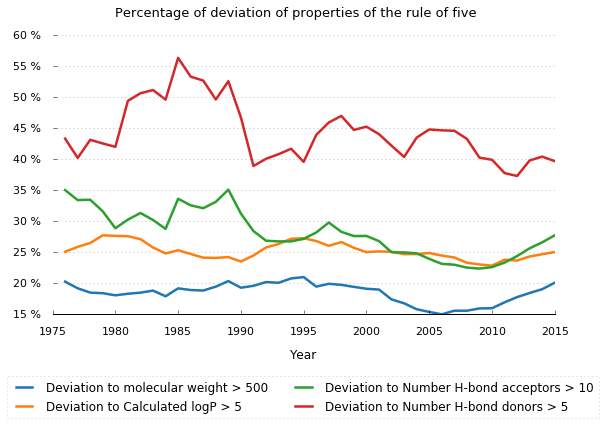

In [24]:
years,years1,years2,years3 = [],[],[],[]
occ,occ1,occ2,occ3 = [],[],[],[]
labels=[]
for k,v in sorted(outlierLipinski.items()):
    if k[0] == 'MolWt':
        years.append(k[1])
        mean_v=((np.array(v)-500.0)/500.0).mean()
        std_v=np.std(((np.array(v)-500.0)/500.0))
        occ.append([100.0*mean_v,100*(mean_v+std_v),100*(mean_v-std_v)])
    if k[0] == 'MolLogP':
        years1.append(k[1])
        mean_v=((np.array(v)-5.0)/5.0).mean()
        std_v=np.std(((np.array(v)-5.0)/5.0))
        occ1.append([100.0*mean_v,100*(mean_v+std_v),100*(mean_v-std_v)])
    if k[0] == 'NumLipinskiHBA':
        years2.append(k[1])
        mean_v=((np.array(v)-10.0)/10.0).mean()
        std_v=np.std(((np.array(v)-10.0)/10.0))
        occ2.append([100.0*mean_v,100*(mean_v+std_v),100*(mean_v-std_v)])
    if k[0] == 'NumLipinskiHBD':
        years3.append(k[1])
        mean_v=((np.array(v)-5.0)/5.0).mean()
        std_v=np.std(((np.array(v)-5.0)/5.0))
        occ3.append([100.0*mean_v,100*(mean_v+std_v),100*(mean_v-std_v)])

fig, ax = plt.subplots(figsize=(9,5),dpi=300)

plt.plot(years,sliding_window(np.array(occ)[:,0]), color=colors[0],label="Deviation to molecular weight > 500",linewidth=2.5)
plt.plot(years1,sliding_window(np.array(occ1)[:,0]), color=colors[2],label="Deviation to Calculated logP > 5",linewidth=2.5)
plt.plot(years2,sliding_window(np.array(occ2)[:,0]), color=colors[3],label="Deviation to Number H-bond acceptors > 10",linewidth=2.5)
plt.plot(years3,sliding_window(np.array(occ3)[:,0]), color=colors[5],label="Deviation to Number H-bond donors > 5",linewidth=2.5)

setPlotProperties(fig,ax) 
lgd=plt.legend(bbox_to_anchor=(1.1, -0.2), frameon=True,ncol=2)
lgd.get_frame().set_facecolor('white')
lgd.get_frame().set_edgecolor('lightgray')
lgd.get_frame().set_linestyle(':')
plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)
ttl=fig.suptitle('Percentage of deviation of properties of the rule of five', fontsize=13)